Required Assignment 11.1: What Drives the Price of a Car?

Overview
This project explores a used car dataset: vehicles.csv of 426,000 used cars (sampled from the original Kaggle dataset of 3 million entries) with the goal of identifying the key factors that influence used car prices. The analysis follows the CRISP-DM (Cross Industry Standard Process for Data Mining) methodology to ensure a structured and repeatable approach.

Data
A used car dataset:vehicles.csv, will be used.  The dataset is sampled from the Kaggle dataset.

Final deliverable
The final deliverable provides actionable insights and recommendations to a client—a used car dealership—on what consumers value most when purchasing a used car.




###1. Business Understanding
Objective:
  -Identify what makes cars more or less expensive.
  -Translate business problem into analytical questions
  (e.g., “How do mileage, age, and brand affect price?”)





Input the libraries and set up the data structure

In [7]:

import warnings, os, re, math
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, HuberRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Paths & constants
DATA_DIR = Path('data'); IMG_DIR = Path('images')
DATA_DIR.mkdir(exist_ok=True); IMG_DIR.mkdir(exist_ok=True)

RANDOM_STATE=42; CV_SPLITS=5; CURRENT_YEAR=2025
PRICE_MIN, PRICE_MAX = 1_000, 100_000
AGE_MAX, ODO_MAX = 30, 300_000

OUT_SUMMARY = DATA_DIR/'model_summary.csv'
OUT_ERRORS  = DATA_DIR/'top_abs_errors.csv'
OUT_CLEAN   = DATA_DIR/'vehicles_clean.csv'


###2. Data Understanding (EDA)

a. understand the dataset

b. display the size, type, features of the dataset

c. plot out the following graphs:
   - missing items situation on the features
   - zero value items situation on the numeric features
   - car's age distribution
   - odometer value distribution
   - price distribution


Raw shape: (426880, 18)


,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc



.info():
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 

,missing_count,missing_pct
size,306361,71.77
cylinders,177678,41.62
condition,174104,40.79
VIN,161042,37.73
drive,130567,30.59
paint_color,130203,30.50
type,92858,21.75
manufacturer,17646,4.13
title_status,8242,1.93
model,5277,1.24



Zero-filled numerics (raw):


,zeros_count,zeros_pct
price,32895,7.71
odometer,1965,0.46
id,0,0.00
year,0,0.00


Saved: images/missingness_topN.png


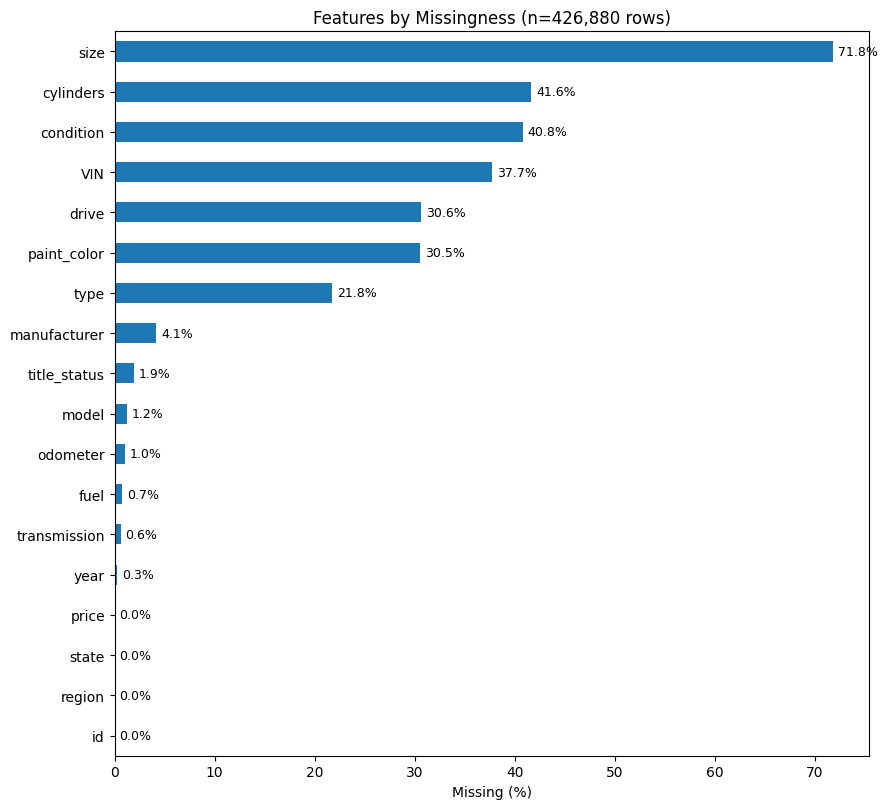

Saved: images/zeros_topN_numeric.png


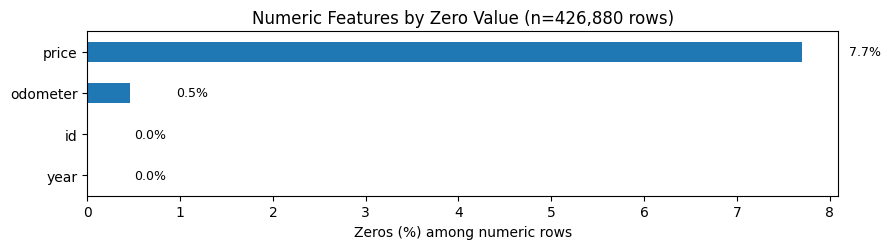

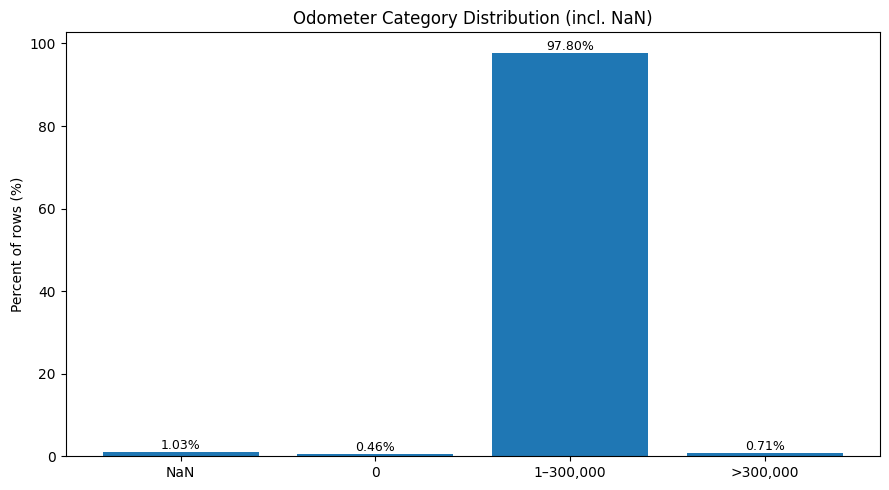

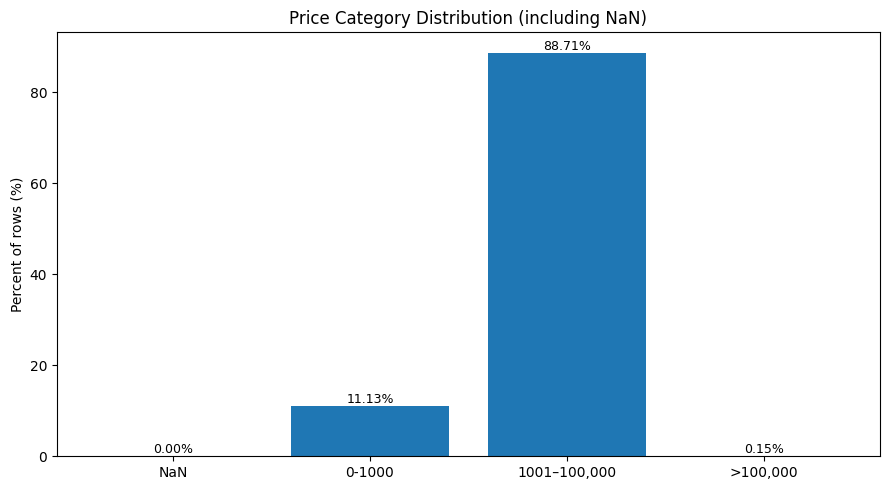

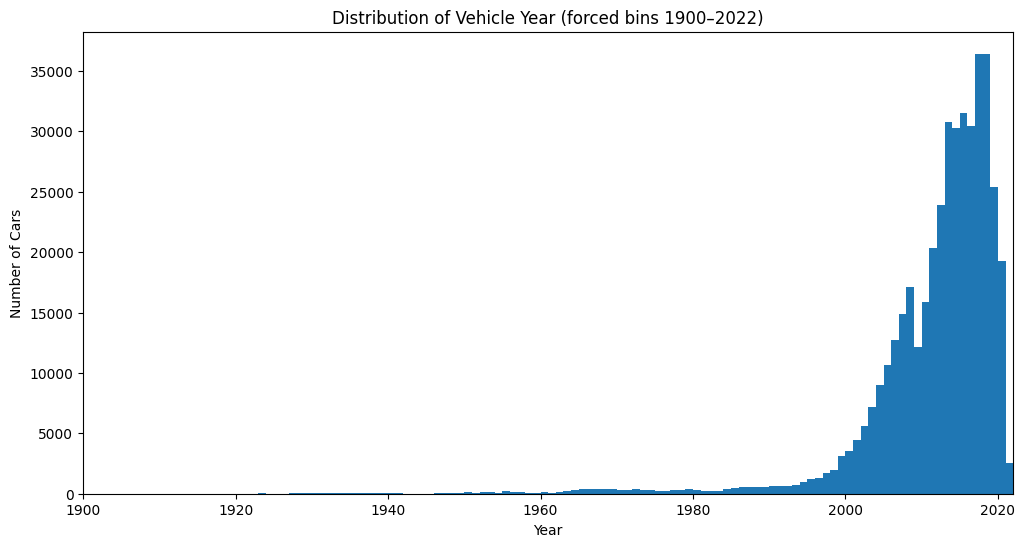

Min year in data (coerced int): 1900
Max year in data (coerced int): 2022


In [8]:

# Load raw
path = DATA_DIR/'vehicles.csv'
assert path.exists(), "Upload your dataset to data/vehicles.csv (relative to this notebook)"
df0 = pd.read_csv(path)
print("Raw shape:", df0.shape)
display(df0.head())

print("\n.info():")
df0.info()

#display the counts and percentage of missing iterms for all feature
def missing_table(df: pd.DataFrame):
    n = len(df)
    miss_ct = df.isna().sum()
    miss_pct = (miss_ct / max(n,1) * 100).round(2)
    return pd.DataFrame({'missing_count': miss_ct, 'missing_pct': miss_pct}).sort_values('missing_pct', ascending=False)

#display the counts and percentage of zero value for numeric features
def zeros_table(df: pd.DataFrame):
    num_cols = df.select_dtypes(include=[np.number]).columns
    z = {}
    n = len(df)
    for c in num_cols:
        z[c] = int((df[c]==0).sum())
    out = pd.DataFrame({'zeros_count': pd.Series(z)})
    out['zeros_pct'] = (out['zeros_count']/max(n,1)*100).round(2)
    return out.sort_values('zeros_pct', ascending=False)

print("\nMissingness (raw):"); display(missing_table(df0).head(30))
print("\nZero-filled numerics (raw):"); display(zeros_table(df0).head(30))


IMG_DIR = Path("images"); IMG_DIR.mkdir(parents=True, exist_ok=True)

#plot the percentage of missing items for all features
def plot_missingness(df, top_n=30, save=True, fname="missingness_topN.png"):
    n = len(df)
    miss_ct  = df.isna().sum()
    miss_pct = (miss_ct / max(n,1) * 100)

    # keep only columns with any missing
    miss = (pd.DataFrame({"missing_pct": miss_pct})
            .query("missing_pct >= 0")
            .sort_values("missing_pct", ascending=False)
            .head(top_n))

    if miss.empty:
        print("No missing values detected.")
        return

    fig, ax = plt.subplots(figsize=(9, 0.4*len(miss)+1))
    miss["missing_pct"].sort_values().plot(kind="barh", ax=ax)
    ax.set_xlabel("Missing (%)")
    ax.set_ylabel("")
    ax.set_title(f"Features by Missingness (n={n:,} rows)")
    for y, v in enumerate(miss["missing_pct"].sort_values().values):
        ax.text(v + 0.5, y, f"{v:.1f}%", va="center", fontsize=9)
    plt.tight_layout()
    if save:
        out = IMG_DIR / fname
        plt.savefig(out, dpi=140)
        print(f"Saved: {out}")
    plt.show()

#plot the percentage of zero value for the numeric features
def plot_zeros(df, top_n=30, save=True, fname="zeros_topN_numeric.png"):
    n = len(df)
    num_cols = df.select_dtypes(include=[np.number]).columns
    if len(num_cols) == 0:
        print("No numeric columns found.")
        return

    zeros_ct = (df[num_cols] == 0).sum()
    zeros_pct = (zeros_ct / max(n,1) * 100)

    # keep only columns with any zeros
    z = (pd.DataFrame({"zeros_pct": zeros_pct})
         .query("zeros_pct >= 0")
         .sort_values("zeros_pct", ascending=False)
         .head(top_n))

    if z.empty:
        print("No zero-filled numeric features detected.")
        return

    fig, ax = plt.subplots(figsize=(9, 0.4*len(z)+1))
    z["zeros_pct"].sort_values().plot(kind="barh", ax=ax)
    ax.set_xlabel("Zeros (%) among numeric rows")
    ax.set_ylabel("")
    ax.set_title(f"Numeric Features by Zero Value (n={n:,} rows)")
    for y, v in enumerate(z["zeros_pct"].sort_values().values):
        ax.text(v + 0.5, y, f"{v:.1f}%", va="center", fontsize=9)
    plt.tight_layout()
    if save:
        out = IMG_DIR / fname
        plt.savefig(out, dpi=140)
        print(f"Saved: {out}")
    plt.show()

plot_missingness(df0, top_n=30)      # missing % by column
plot_zeros(df0, top_n=30)

#Plot distribution of odometer value
def odom_bucket_nan(x):
    if pd.isna(x):
        return "NaN"
    elif x == 0:
        return "0"
    elif 0 < x <= 300_000:
        return "1–300,000"
    elif x > 300_000:
        return ">300,000"
    else:
        # negative or weird -> treat as NaN-equivalent for summary
        return "NaN"

N = len(df0)  # include NaNs in denominator
df0["odometer"] = pd.to_numeric(df0["odometer"], errors="coerce")
cats = df0["odometer"].map(odom_bucket_nan)
order = ["NaN", "0", "1–300,000", ">300,000"]
counts = cats.value_counts().reindex(order, fill_value=0)
perc = (counts / N * 100).round(2)

odom_nan_tbl = pd.DataFrame({
    "odometer_category": order,
    "count": [int(counts[c]) for c in order],
    "percent": [float(perc[c]) for c in order]
})

# Plot
plt.figure(figsize=(9,5))
plt.bar(odom_nan_tbl["odometer_category"], odom_nan_tbl["percent"])
plt.ylabel("Percent of rows (%)")
plt.title("Odometer Category Distribution (incl. NaN)")
for i, v in enumerate(odom_nan_tbl["percent"]):
    plt.text(i, v, f"{v:.2f}%", ha="center", va="bottom", fontsize=9)
plt.tight_layout()
plt.savefig(IMG_DIR/'odometer_distributions_bar.png', dpi=120)
plt.show()

#plot price distribution
def price_bucket_nan(x):
    if pd.isna(x):
        return "NaN"
    elif x <= 1000:
        return "0-1000"
    elif 1000 < x <= 100_000:
        return "1001–100,000"
    elif x > 100_000:
        return ">100,000"
    else:
        # Negative or weird values; treat as NaN-equivalent for this summary
        return "NaN"

# Keep original length to compute NaN share
N = len(df0)
# Coerce price to numeric, but DO NOT drop NaNs (we want to count them)
df0["price"] = pd.to_numeric(df0["price"], errors="coerce")
cats = df0["price"].map(price_bucket_nan)

order = ["NaN", "0-1000", "1001–100,000", ">100,000"]
counts = cats.value_counts().reindex(order, fill_value=0)
perc = (counts / N * 100).round(2)

price_nan_tbl = (
    pd.DataFrame({"price_category": order,
                  "count": [int(counts[c]) for c in order],
                  "percent": [float(perc[c]) for c in order]})
)

# Plot percentage bar chart
plt.figure(figsize=(9,5))
plt.bar(price_nan_tbl["price_category"], price_nan_tbl["percent"])
plt.ylabel("Percent of rows (%)")
plt.title("Price Category Distribution (including NaN)")
for i, v in enumerate(price_nan_tbl["percent"]):
    plt.text(i, v, f"{v:.2f}%", ha="center", va="bottom", fontsize=9)
plt.tight_layout()
plt.savefig(IMG_DIR/'price_distributions_bar.png', dpi=120)
plt.show()

# YEAR: histogram forced 1900–2022
year = df0["year"].dropna().astype(int)
bins = np.arange(1900, 2023, 1)
plt.figure(figsize=(12,6))
plt.hist(year, bins=bins, edgecolor="none")
plt.xlim(1900, 2022)
plt.xlabel("Year")
plt.ylabel("Number of Cars")
plt.title("Distribution of Vehicle Year (forced bins 1900–2022)")
plt.savefig(IMG_DIR/'vehicle_distribution.png', dpi=120)
plt.show()

print("Min year in data (coerced int):", int(year.min()) if len(year)>0 else None)
print("Max year in data (coerced int):", int(year.max()) if len(year)>0 else None)

# Numeric distributions & correlation heat map
num_cols = df0.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [c for c in num_cols if c not in ['lat','long']]

if len(num_cols) >= 1:
    n = min(6, len(num_cols))
    fig, axes = plt.subplots(nrows=n, ncols=1, figsize=(8, 3*n))
    if n == 1: axes=[axes]
    for ax, c in zip(axes, num_cols[:n]):
        sns.histplot(df0[c].dropna(), bins=40, kde=False, ax=ax)
        ax.set_title(f"Distribution: {c}")
    fig.tight_layout()
    plt.savefig(IMG_DIR/'numeric_distributions_top6.png', dpi=120)
    plt.close(fig)
else:
    print("No numeric columns found for histograms.")

if len(num_cols) >= 2:
    corr = df0[num_cols].corr()
    plt.figure(figsize=(8,6))
    sns.heatmap(corr, cmap='vlag', center=0, annot=False)
    plt.title("Correlation Heat Map (numeric)")
    plt.tight_layout()
    plt.savefig(IMG_DIR/'corr_heatmap.png', dpi=120)
    plt.close()
else:
    print("Fewer than 2 numeric columns; skipping correlation heat map.")



### 3 Data Preparation

Data Cleaning

  -Feature removal:
    
    Dropped id and VIN because they are unrelated to price.

    Dropped size due to excessive missing values (>70%).

    Dropped model because the descriptions were inconsistent and not standardized.

  -Outlier capping:
    Applied caps to extreme values for key numeric features:
      
      Price: limited to $3,000 – $100,000

      Age: maximum of 30 years

      Odometer: maximum of 300,000 miles

  -Missing value imputation:
    Categorical features → imputed with mode

    Numeric features → imputed with median
  

In [9]:

df = df0.copy()

# 2.1 Drop redundant columns and 'model' (too messy)
drop_cols_fixed = [c for c in ['id','ID','vin','VIN','region','Region','model'] if c in df.columns]
df.drop(columns=drop_cols_fixed, inplace=True, errors='ignore')

# 2.2 Columns-first missing drop (decide on RAW); keep ordinals even if sparse
protect = set(['condition','cylinders','title_status','drive'])
miss0 = df0.isna().mean()
high_miss_cols0 = [c for c,p in miss0.items() if p>0.70 and c not in protect and c in df.columns]
df.drop(columns=high_miss_cols0, inplace=True, errors='ignore')

# 2.3 Coerce numerics
for c in ['price','year','odometer']:
    if c in df.columns: df[c] = pd.to_numeric(df[c], errors='coerce')

# 2.4 Row hygiene
bad = (df['price'].isna()| (df['price']==0)) & (df['year'].isna()| (df['year']==0))
df = df.loc[~bad].copy()
if 'odometer' in df.columns:
    bad2 = (df['year'].isna()| (df['year']==0)) & (df['odometer'].isna()| (df['odometer']==0))
    df = df.loc[~bad2].copy()

# 2.5 Outlier rules (no MPY)
df = df[(df['price']>=PRICE_MIN) & (df['price']<=PRICE_MAX)]
df['age'] = CURRENT_YEAR - df['year']
df = df[(df['age'].isna()) | (df['age']<=AGE_MAX)]
df = df[(df['odometer'].isna()) | (df['odometer']<=ODO_MAX)]
df.loc[df['odometer']==0, 'odometer']=np.nan

# 2.6 Normalize text
def norm(s): return s.astype(str).str.strip().str.lower()
for c in ['manufacturer','fuel','type','state','condition','cylinders','title_status','drive']:
    if c in df.columns: df[c]=norm(df[c])

# 2.7 Ordinals
cond_map  = {'salvage':0,'fair':1,'good':2,'excellent':3,'like new':4,'new':5}
title_map = {'salvage':0,'rebuilt':1,'lien':2,'missing':2,'parts only':2,'clean':3}
drive_map = {'fwd':0,'rwd':1,'4wd':2,'awd':2}

#the parse_cyl(s) return the first/first+ digit in the string.
#re is the standard library of and let us to do search.
#this function is mainly for cylinders column
def parse_cyl(x):
    if pd.isna(x): return np.nan
    m = re.search(r'(\d{1,2})', str(x))
    return float(m.group(1)) if m else np.nan

df['condition_ord']    = df['condition'].map(cond_map)    if 'condition'    in df.columns else np.nan
df['title_status_ord'] = df['title_status'].map(title_map)if 'title_status' in df.columns else np.nan
df['drive_ord']        = df['drive'].map(drive_map)       if 'drive'        in df.columns else np.nan
df['cylinders_num']    = df['cylinders'].map(parse_cyl)   if 'cylinders'    in df.columns else np.nan

# 2.8 Impute numerics (median)
for c in ['year','odometer','age','condition_ord','title_status_ord','drive_ord','cylinders_num']:
    if c in df.columns:
        med = float(np.nanmedian(df[c])) if df[c].notna().any() else 0.0   #median ignore nan
        df[c] = df[c].fillna(med)

# NOTE: Do NOT fill categoricals here (we'll impute with TRAIN MODE later).

# 2.9 Engineered features
df['odometer_10k']    = df['odometer']/10_000.0
df['odometer_10k_sq'] = (df['odometer_10k']**2).astype(float)

# Optional year bins
if 'year' in df.columns:
    df['year_bin'] = pd.cut(df['year'], bins=[1980,2000,2005,2010,2015,2020,2025],
                            labels=False, include_lowest=True).fillna(-1).astype(int)

df.to_csv(OUT_CLEAN, index=False)
print("Cleaned shape:", df.shape, "| saved:", OUT_CLEAN)


Cleaned shape: (362744, 21) | saved: data/vehicles_clean.csv


### OOF James–Stein encoders on **log(price)**
Create routine to fills the encoding value for catgoricals features:

oof_te_fit_transform_log: Learns a shrunk target mean per category and return OOF-encoded Series and mapping+global mean

te_transform_from_map:Applies the saved mapping to any new series

In [10]:

from sklearn.model_selection import KFold

#Learns a shrunk target mean per category and return OOF-encoded Series and mapping+global mean
def oof_te_fit_transform_log(x_train, y_train_log, alpha=8.0, n_splits=5, random_state=42):
    s = x_train.astype(str).fillna('<NA>')
    idx = np.arange(len(s))
    #instantiate a KFold object
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    #create a y log space
    y = y_train_log.astype(float)
    mu_g = float(np.mean(y))
    oof = pd.Series(index=s.index, dtype=float)
    #tr:fold's training row, va:fold's validation row
    for tr, va in kf.split(idx):
        s_tr, y_tr = s.iloc[tr], y[tr]
        mu = float(np.mean(y_tr))
        g = pd.DataFrame({'cat':s_tr, 'y':y_tr}).groupby('cat')['y'].agg(['mean','size'])

        #encoding based on James-Stein algorithm
        enc = ((g['size']*g['mean'] + alpha*mu) / (g['size']+alpha)).to_dict()  #put to dictionary, used as look up table
        #fill validification row of oof with mean value
        oof.iloc[va] = s.iloc[va].map(enc).fillna(mu).values

    g_full = pd.DataFrame({'cat':s, 'y':y}).groupby('cat')['y'].agg(['mean','size'])  #final data set, not cv data set
    enc_full = ((g_full['size']*g_full['mean'] + alpha*mu_g) / (g_full['size']+alpha)).to_dict()  # calculate enc value for final data set
    oof = oof.fillna(s.map(enc_full)).fillna(mu_g)
    return oof.astype(float), (enc_full, mu_g)  # return oof, full enc and mean

#Applies the saved mapping to any new series
def te_transform_from_map(x_series, mapping_and_mu):
    enc_full, mu = mapping_and_mu
    s = x_series.astype(str).fillna('<NA>')
    return s.map(enc_full).fillna(mu).astype(float)


a. Perform an 80/20 Train–Test split.  
b. Impute missing values in categorical features using the mode.  
c. Apply James–Stein encoding to high-cardinality categorical features (e.g., manufacturer).  
d. Assign ordinal values to naturally ordered categorical variables (e.g., cylinders).  
e. Use Sequential Feature Selection (SFS) to identify the six features with the lowest MAE.  

In [11]:

# Split
tr_idx, te_idx = train_test_split(df.index, test_size=0.2, random_state=RANDOM_STATE)
y_tr = df.loc[tr_idx, 'price'].values.astype(float)
y_te = df.loc[te_idx, 'price'].values.astype(float)
ytr_log = np.log(y_tr.clip(PRICE_MIN, PRICE_MAX))

# TRAIN-mode fills for categoricals (no leakage)
cat_cols = [c for c in ['manufacturer','fuel','type','state'] if c in df.columns]
mode_fills = {}
for c in cat_cols:
    m = df.loc[tr_idx, c].dropna().mode()
    mode_fills[c] = str(m.iloc[0]) if len(m) else 'unknown'

# Base numeric/ordinal candidates
base_cols = ['year','year_bin','age','odometer_10k','odometer_10k_sq',
             'condition_ord','cylinders_num','title_status_ord','drive_ord']
base_cols = [c for c in base_cols if c in df.columns]

Xtr = df.loc[tr_idx, base_cols].copy()
Xte = df.loc[te_idx, base_cols].copy()

# TEs on simple categories with TRAIN-mode fill
encs = {}
for col, alpha in [('manufacturer',8.0), ('fuel',10.0), ('type',12.0), ('state',15.0)]:
    if col in df.columns:
        #fill NaN with mode
        xtr = df.loc[tr_idx, col].fillna(mode_fills[col])
        #calculate JS value
        oof_vals, mp = oof_te_fit_transform_log(xtr, ytr_log, alpha=alpha, n_splits=CV_SPLITS, random_state=RANDOM_STATE)
        #assign the JS value column
        encs[f'js_{col}'] = (oof_vals, mp)

for name,(oof_vals, mp) in encs.items():
    Xtr[name] = oof_vals.values
    src = name.replace('js_','')
    Xte[name] = te_transform_from_map(df.loc[te_idx, src].fillna(mode_fills[src]), mp).values

print("SFS candidates:", len(Xtr.columns))
print(sorted(list(Xtr.columns)))


SFS candidates: 13
['age', 'condition_ord', 'cylinders_num', 'drive_ord', 'js_fuel', 'js_manufacturer', 'js_state', 'js_type', 'odometer_10k', 'odometer_10k_sq', 'title_status_ord', 'year', 'year_bin']


In [12]:

from sklearn.linear_model import Ridge

candidates = list(Xtr.columns)
selected = []

def cv_score(cols):
    pipe = Pipeline([('imp', SimpleImputer(strategy='median')),
                     ('sc', StandardScaler()),
                     ('reg', Ridge(alpha=1.0))])
    scores = cross_val_score(pipe, Xtr[cols], ytr_log,
                             cv=KFold(n_splits=CV_SPLITS, shuffle=True, random_state=RANDOM_STATE),
                             scoring='neg_mean_squared_error')
    return float(np.mean(scores))

target_k = min(6, len(candidates))
while len(selected) < target_k and candidates:
    best_c, best_sc = None, -np.inf
    for c in candidates:
        sc = cv_score(selected + [c])
        if sc > best_sc:
            best_sc, best_c = sc, c
    selected.append(best_c); candidates.remove(best_c)
    print(f"Add: +{best_c} (CV neg-MSE={best_sc:.6f})")

print("Selected 6:", selected)
if len(selected) < 6:
    print(f"WARNING: Only {len(selected)} features available for SFS: {len(selected)}")


Add: +year (CV neg-MSE=-0.370911)
Add: +cylinders_num (CV neg-MSE=-0.302077)
Add: +js_type (CV neg-MSE=-0.273014)
Add: +odometer_10k (CV neg-MSE=-0.247372)
Add: +js_fuel (CV neg-MSE=-0.227011)
Add: +drive_ord (CV neg-MSE=-0.212090)
Selected 6: ['year', 'cylinders_num', 'js_type', 'odometer_10k', 'js_fuel', 'drive_ord']


## 5. Modeling & Evaluation

a. Run **5-fold Cross Validation (CV)** on the 80% training set to tune and select the best hyperparameters.  

b. Refit the model on the full 80% training data using the selected hyperparameters to obtain the final model.  

c. Evaluate the final model on the untouched 20% test set by predicting car prices and computing performance metrics.  

In [15]:

models = [
    ('OLS', LinearRegression(), None),
    ('Ridge', Ridge(), {'reg__alpha':[1e-3,1e-2,1e-1,1,10,100]}),
    ('Lasso', Lasso(max_iter=20000), {'reg__alpha':[1e-4,1e-3,1e-2,1e-1,1]}),
    ('ElasticNet', ElasticNet(max_iter=20000), {'reg__alpha':[1e-4,1e-3,1e-2,1e-1], 'reg__l1_ratio':[0.1,0.5,0.9]}),
    ('Huber', HuberRegressor(), {'reg__epsilon':[1.2,1.5,1.8,2.5], 'reg__alpha':[1e-6,1e-5,1e-4,1e-3]}),
]

def duan_smear(y_true_log, y_pred_log):
    resid = y_true_log - y_pred_log
    return float(np.mean(np.exp(resid)))

def trimmed(y_true, y_pred, p=0.02):
    ae = np.abs(y_true - y_pred)
    n=len(ae)
    k=int(np.floor(p*n))
    if k>0 and 2*k<n:
        keep = np.argsort(ae)[k:n-k]
        yt, yp = y_true[keep], y_pred[keep]
    else:
        yt, yp = y_true, y_pred
    rmse = float(np.sqrt(mean_squared_error(yt, yp)))
    mae  = float(mean_absolute_error(yt, yp))
    return rmse, mae

rows, preds = [], {}
fitted = {}  # NEW: keep fitted pipelines by model name

for name, est, grid in models:
    pipe = Pipeline([
        ('imp', SimpleImputer(strategy='median')),
        ('sc', StandardScaler()),
        ('reg', est)
    ])
    if grid is not None:
        gs = GridSearchCV(
            pipe, grid, scoring='neg_mean_squared_error',
            cv=KFold(n_splits=CV_SPLITS, shuffle=True, random_state=RANDOM_STATE),
            refit=True
        )
        gs.fit(Xtr[selected], ytr_log)
        est_fit = gs.best_estimator_; params = gs.best_params_
    else:
        pipe.fit(Xtr[selected], ytr_log); est_fit = pipe; params = {}

    # NEW: store the fitted pipeline for this model
    fitted[name] = est_fit

    ytr_pred_log = est_fit.predict(Xtr[selected])
    smear = duan_smear(ytr_log, ytr_pred_log)

    yte_pred_log = est_fit.predict(Xte[selected])
    p_te = np.clip(np.exp(yte_pred_log) * smear, PRICE_MIN, PRICE_MAX)

    rmse = float(np.sqrt(mean_squared_error(y_te, p_te)))
    mae  = float(mean_absolute_error(y_te, p_te))
    r2d  = float(r2_score(y_te, p_te))
    r2l  = float(r2_score(np.log(y_te.clip(PRICE_MIN,PRICE_MAX)), yte_pred_log))
    rmse_t, mae_t = trimmed(y_te, p_te, p=0.02)

    rows.append({
        'Model':name, 'Best Params':params, 'Selected 6':', '.join(selected),
        'RMSE($)':rmse, 'MAE($)':mae, 'R²_log':r2l, 'R²($)':r2d,
        'RMSE_trim2%($)':rmse_t, 'MAE_trim2%($)':mae_t
    })
    preds[name] = p_te

summary = pd.DataFrame(rows).sort_values('RMSE($)').reset_index(drop=True)
display(summary)
summary.to_csv(OUT_SUMMARY, index=False); print("Saved:", OUT_SUMMARY)

best_name = summary.iloc[0]['Model']
best_pred = preds[best_name]

# ===== NEW: Extract coefficient table for the final (best) model =====
best_pipe = fitted[best_name]
reg = best_pipe.named_steps['reg']

# Coefs on the STANDARDIZED feature scale (i.e., after StandardScaler)
coef_std = getattr(reg, 'coef_', None)
intercept_std = getattr(reg, 'intercept_', None)

coef_df_std = None
if coef_std is not None:
    coef_df_std = pd.DataFrame({
        'feature': selected,
        'coef_std': coef_std
    }).assign(abs_coef=lambda d: d['coef_std'].abs()).sort_values('abs_coef', ascending=False)
    print(f"\n[{best_name}] Coefficients on standardized scale (target is log-price):")
    display(coef_df_std[['feature','coef_std']])

# Map coefficients back to ORIGINAL feature units
# beta_orig = beta_std / scale_;  intercept_orig = intercept_std - sum(beta_std * mean_/scale_)
scaler = best_pipe.named_steps['sc']
if coef_std is not None and hasattr(scaler, 'scale_') and hasattr(scaler, 'mean_'):
    beta_orig = coef_std / scaler.scale_
    intercept_orig = float(intercept_std - np.sum(coef_std * scaler.mean_ / scaler.scale_))
    coef_df_orig = pd.DataFrame({
        'feature': selected,
        'coef_original_units': beta_orig
    }).assign(abs_coef=lambda d: d['coef_original_units'].abs()).sort_values('abs_coef', ascending=False)

    print(f"\n[{best_name}] Coefficients mapped to ORIGINAL feature units (still for log-price):")
    display(coef_df_orig[['feature','coef_original_units']])

    print(f"\n[{best_name}] Intercepts:")
    print("intercept (standardized features):", intercept_std)
    print("intercept (original feature units):", intercept_orig)
else:
    print("\nScaler stats not available; only standardized coefficients shown.")

,Model,Best Params,Selected 6,RMSE($),MAE($),R²_log,R²($),RMSE_trim2%($),MAE_trim2%($)
0,Huber,"{'reg__alpha': 0.001, 'reg__epsilon': 2.5}","year, cylinders_num, js_type, odometer_10k, js...",8823.150950,5837.659077,0.694194,0.621666,7389.407433,5367.409313
1,Lasso,{'reg__alpha': 0.0001},"year, cylinders_num, js_type, odometer_10k, js...",8831.175428,5837.008993,0.694464,0.620977,7386.253225,5363.875280
2,ElasticNet,"{'reg__alpha': 0.0001, 'reg__l1_ratio': 0.1}","year, cylinders_num, js_type, odometer_10k, js...",8832.491834,5837.637211,0.694465,0.620864,7387.389028,5364.415106
3,Ridge,{'reg__alpha': 10},"year, cylinders_num, js_type, odometer_10k, js...",8832.863577,5837.820147,0.694466,0.620832,7387.724159,5364.576595
4,OLS,{},"year, cylinders_num, js_type, odometer_10k, js...",8832.984490,5837.880880,0.694466,0.620822,7387.836299,5364.631111


Saved: data/model_summary.csv

[Huber] Coefficients on standardized scale (target is log-price):


,feature,coef_std
0,year,0.409527
3,odometer_10k,-0.237094
1,cylinders_num,0.150925
4,js_fuel,0.141420
5,drive_ord,0.137607
2,js_type,0.107624



[Huber] Coefficients mapped to ORIGINAL feature units (still for log-price):


,feature,coef_original_units
4,js_fuel,0.551114
2,js_type,0.341770
5,drive_ord,0.182561
1,cylinders_num,0.124796
0,year,0.074758
3,odometer_10k,-0.038593



[Huber] Intercepts:
intercept (standardized features): 9.592639809522472
intercept (original feature units): -149.99275674759303
